<a href="https://colab.research.google.com/github/MaDufie/airline_delay_prediction/blob/main/airlines_delay_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Airline Delay Prediction**
Downloaded data from: https://www.kaggle.com/datasets/ulrikthygepedersen/airlines-delay?resource=download



# **Data Preparation**

## Importing dependencies



In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Loading the dataset


In [3]:
df = pd.read_csv('/content/drive/MyDrive/My ML Journey/airlines_delay_prediction/airlines_delay.csv')
df

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0
...,...,...,...,...,...,...,...,...
539377,6973.0,530.0,72.0,OO,GEG,SEA,5,1
539378,1264.0,560.0,115.0,WN,LAS,DEN,4,1
539379,5209.0,827.0,74.0,EV,CAE,ATL,2,1
539380,607.0,715.0,65.0,WN,BWI,BUF,4,1


## Checking for Missing Values and Descriptive Statistics

In [4]:
df.isnull().sum()

,0
Flight,0
Time,0
Length,0
Airline,0
AirportFrom,0
AirportTo,0
DayOfWeek,0
Class,0


In [ ]:
df.describe()

,Flight,Time,Length,DayOfWeek,Class
count,539382.000000,539382.000000,539382.000000,539382.000000,539382.000000
mean,2427.927988,802.728161,132.202104,3.929666,0.445443
std,2067.431700,278.045546,70.117045,1.914666,0.497015
min,1.000000,10.000000,0.000000,1.000000,0.000000
25%,712.000000,565.000000,81.000000,2.000000,0.000000
50%,1809.000000,795.000000,115.000000,4.000000,0.000000
75%,3745.000000,1035.000000,162.000000,5.000000,1.000000
max,7814.000000,1439.000000,655.000000,7.000000,1.000000


In [5]:
df.shape

(539382, 8)

In [ ]:
df.columns

Index(['Flight', 'Time', 'Length', 'Airline', 'AirportFrom', 'AirportTo',
       'DayOfWeek', 'Class'],
      dtype='object')

In [ ]:
df.nunique()

,0
Flight,6585
Time,1131
Length,426
Airline,18
AirportFrom,293
AirportTo,293
DayOfWeek,7
Class,2


## Feature Engineering

In [ ]:
df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


### Time of Day for the Flight Departure
The "Time" column in the dataset is represented as the number of minutes past midnight.
*   0 corresponds to 00:00 (midnight).
*   60 corresponds to 01:00 (1:00 AM).
*   720 corresponds to 12:00 (noon).
*   1296 corresponds to 21:36 (9:36 PM).
*   1439 corresponds to 23:59 (11:59 PM).


Time of Day: The time will be categorized into:
*   Morning: 05:00 AM to 11:59 AM (300 to 719 minutes)
*   Afternoon: 12:00 PM to 05:59 PM (720 to 1079 minutes)
*   Evening: 06:00 PM to 09:59 PM (1080 to 1319 minutes)
*   Night: 10:00 PM to 04:59 AM (1320 to 299 minutes, with wrap-around for minutes past midnight)






In [6]:
def get_time_of_day(minutes):
    if 300 <= minutes < 720:
        return 'Morning'
    elif 720 <= minutes < 1080:
        return 'Afternoon'
    elif 1080 <= minutes < 1320:
        return 'Evening'
    else:
        return 'Night'

df['TimeOfDay'] = df['Time'].apply(get_time_of_day)

### Flight Length Buckets

In [7]:
def get_length_bucket(length):
    if length < 120:
        return 'Short'
    elif 120 <= length < 240:
        return 'Medium'
    else:
        return 'Long'

df['LengthBucket'] = df['Length'].apply(get_length_bucket)

In [ ]:
df

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class,TimeOfDay,LengthBucket
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0,Evening,Medium
1,6948.0,360.0,146.0,OO,COS,ORD,4,0,Morning,Medium
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0,Evening,Medium
3,31.0,1410.0,344.0,US,OGG,PHX,6,0,Night,Long
4,563.0,692.0,98.0,FL,BMI,ATL,4,0,Morning,Short
...,...,...,...,...,...,...,...,...,...,...
539377,6973.0,530.0,72.0,OO,GEG,SEA,5,1,Morning,Short
539378,1264.0,560.0,115.0,WN,LAS,DEN,4,1,Morning,Short
539379,5209.0,827.0,74.0,EV,CAE,ATL,2,1,Afternoon,Short
539380,607.0,715.0,65.0,WN,BWI,BUF,4,1,Morning,Short


# **Exploratory Data Analysis**

### Distribution of the Target Variable (Flight Delay)

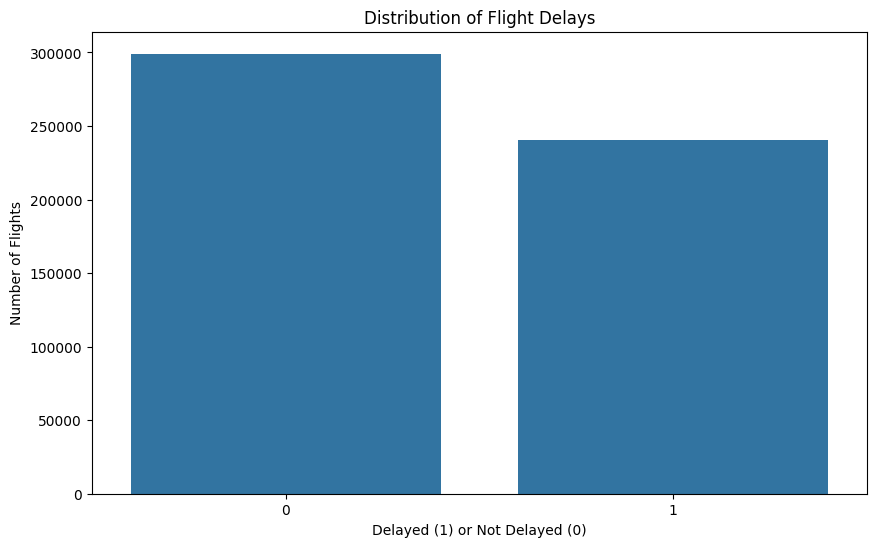

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Class')
plt.title('Distribution of Flight Delays')
plt.xlabel('Delayed (1) or Not Delayed (0)')
plt.ylabel('Number of Flights')
plt.show()

### Time of Day for Departure vs. Flight Delays

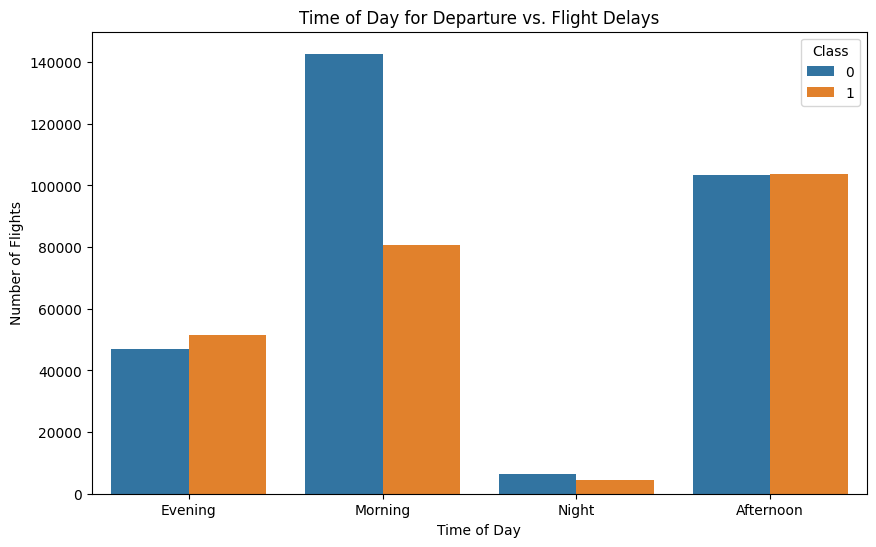

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='TimeOfDay', hue='Class')
plt.title('Time of Day for Departure vs. Flight Delays')
plt.xlabel('Time of Day')
plt.ylabel('Number of Flights')
plt.show()

###  Flight Length vs. Flight Delays

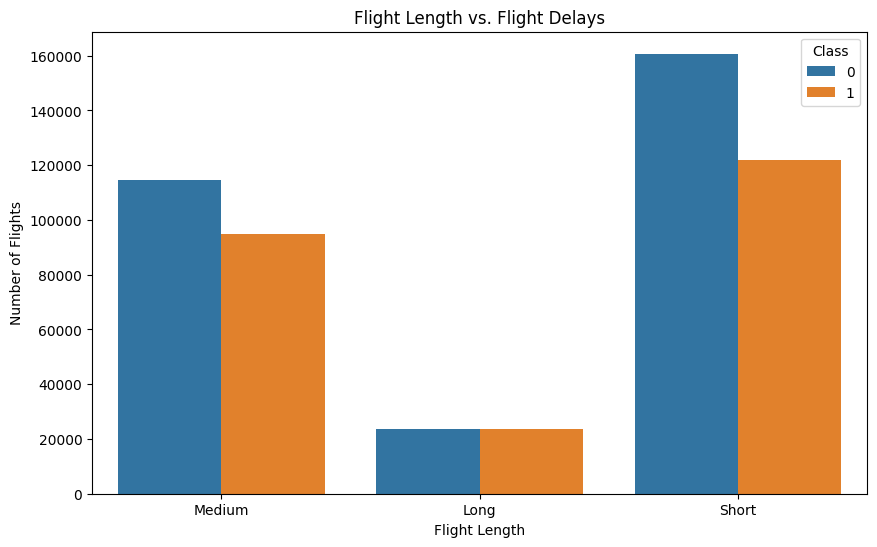

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='LengthBucket', hue='Class')
plt.title('Flight Length vs. Flight Delays')
plt.xlabel('Flight Length')
plt.ylabel('Number of Flights')
plt.show()

### Airline Performance

Text(0, 0.5, 'Number of Flights')

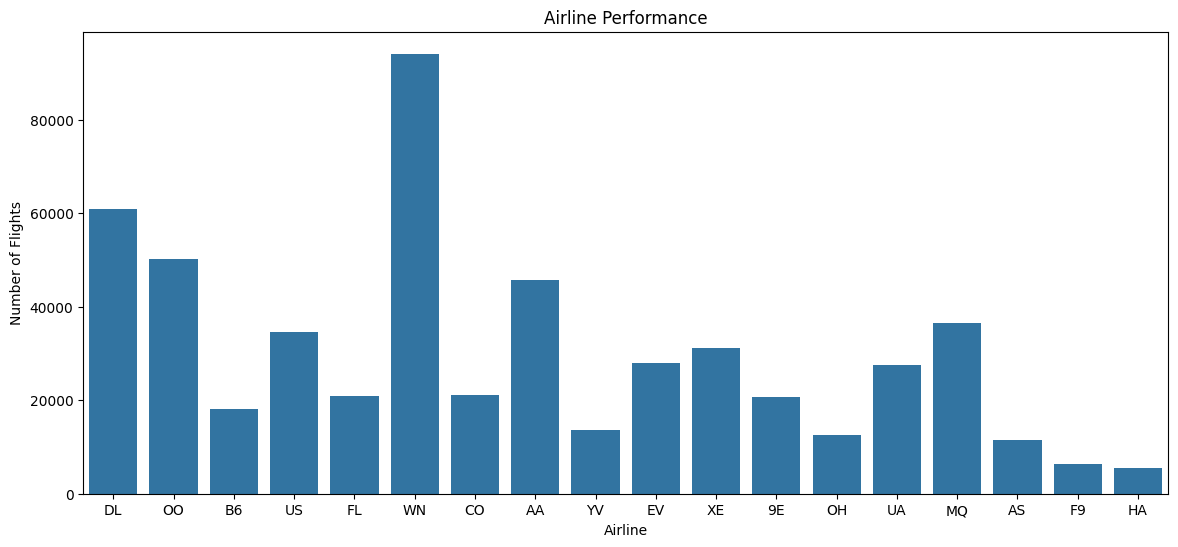

In [ ]:
plt.figure(figsize=(14, 6))
sns.countplot(x='Airline', data=df)
plt.title('Airline Performance')
plt.xlabel('Airline')
plt.ylabel('Number of Flights')

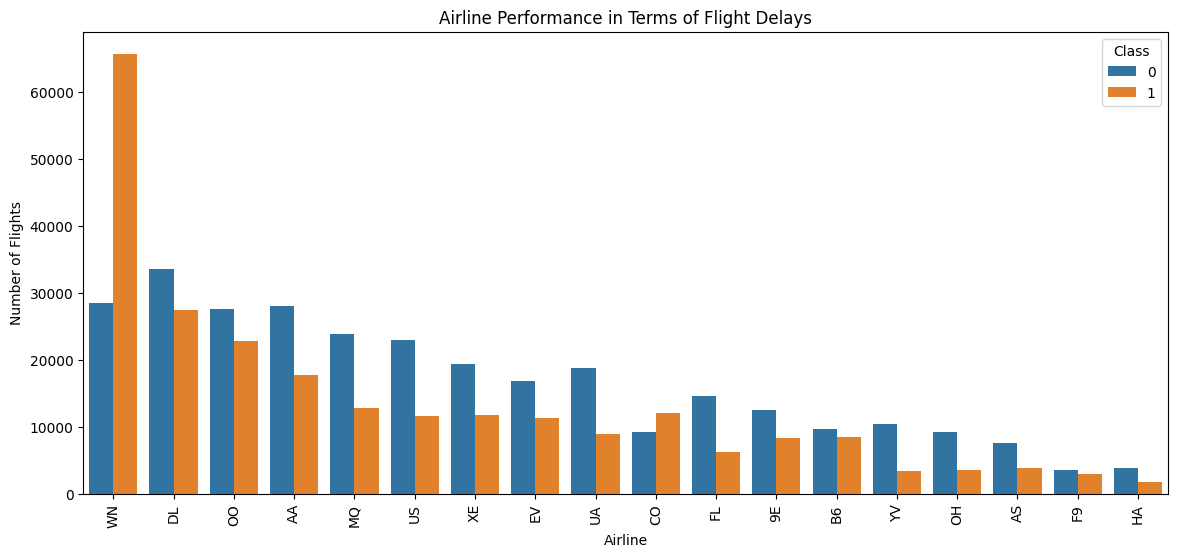

In [ ]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='Airline', hue='Class', order=df['Airline'].value_counts().index)
plt.title('Airline Performance in Terms of Flight Delays')
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.xticks(rotation=90)
plt.show()

### Flights per Day of Week

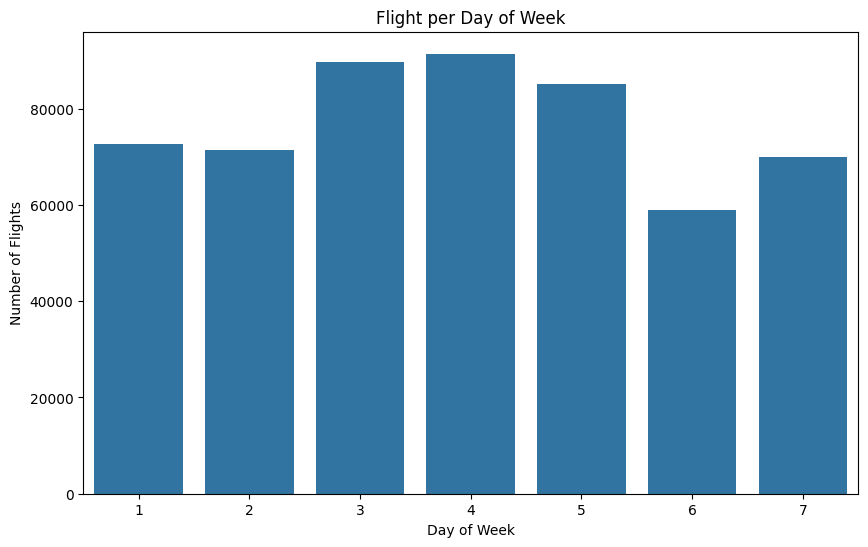

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='DayOfWeek', data=df)
plt.title('Flight per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Flights')
plt.show()

### Day of the Week vs. Flight Delays

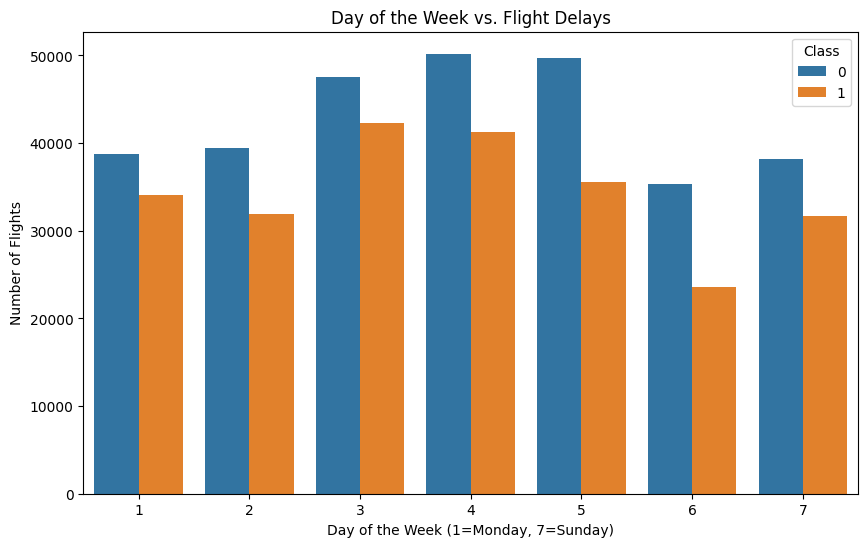

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='DayOfWeek', hue='Class')
plt.title('Day of the Week vs. Flight Delays')
plt.xlabel('Day of the Week (1=Monday, 7=Sunday)')
plt.ylabel('Number of Flights')
plt.show()

### Departure and Arrival Airports vs. Flight Delays

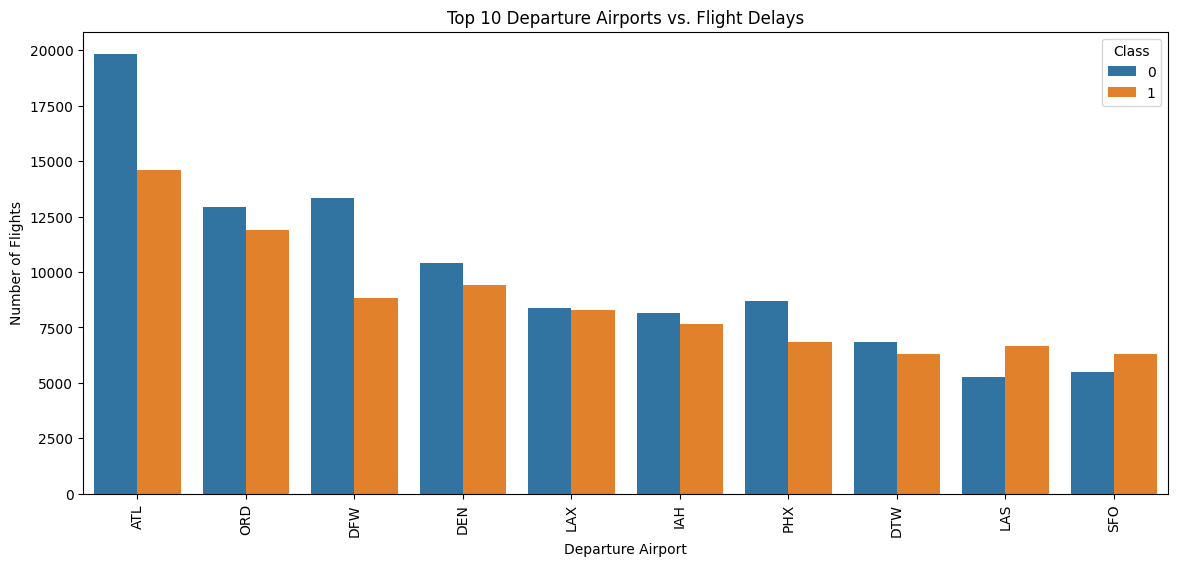

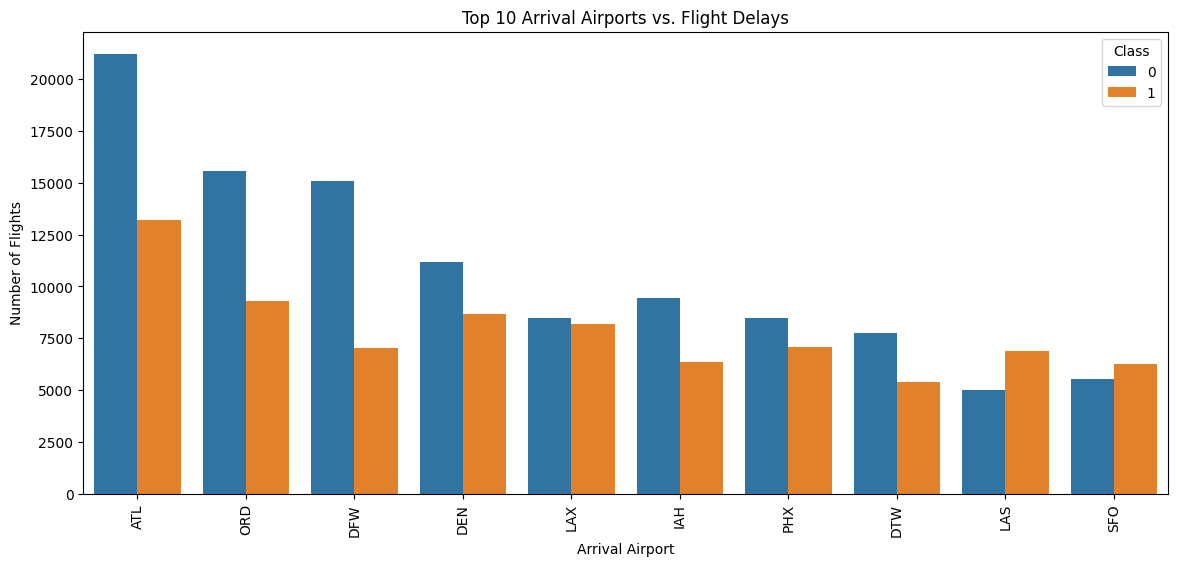

In [ ]:
plt.figure(figsize=(14, 6))
top_airports = df['AirportFrom'].value_counts().nlargest(10).index
sns.countplot(data=df[df['AirportFrom'].isin(top_airports)], x='AirportFrom', hue='Class', order=top_airports)
plt.title('Top 10 Departure Airports vs. Flight Delays')
plt.xlabel('Departure Airport')
plt.ylabel('Number of Flights')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(14, 6))
top_airports_to = df['AirportTo'].value_counts().nlargest(10).index
sns.countplot(data=df[df['AirportTo'].isin(top_airports_to)], x='AirportTo', hue='Class', order=top_airports_to)
plt.title('Top 10 Arrival Airports vs. Flight Delays')
plt.xlabel('Arrival Airport')
plt.ylabel('Number of Flights')
plt.xticks(rotation=90)
plt.show()

## Correlation Matrix of the Data

In [ ]:
numerical_df = df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()

correlation_matrix

             Flight      Time    Length  DayOfWeek     Class
Flight     1.000000 -0.005750 -0.341481   0.000416 -0.046174
Time      -0.005750  1.000000 -0.020610   0.001272  0.150457
Length    -0.341481 -0.020610  1.000000   0.013398  0.040488
DayOfWeek  0.000416  0.001272  0.013398   1.000000 -0.026198
Class     -0.046174  0.150457  0.040488  -0.026198  1.000000


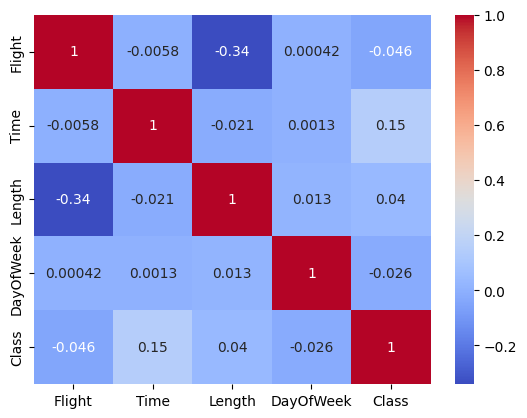

In [ ]:
sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, annot=True, cmap='coolwarm')
plt.show()

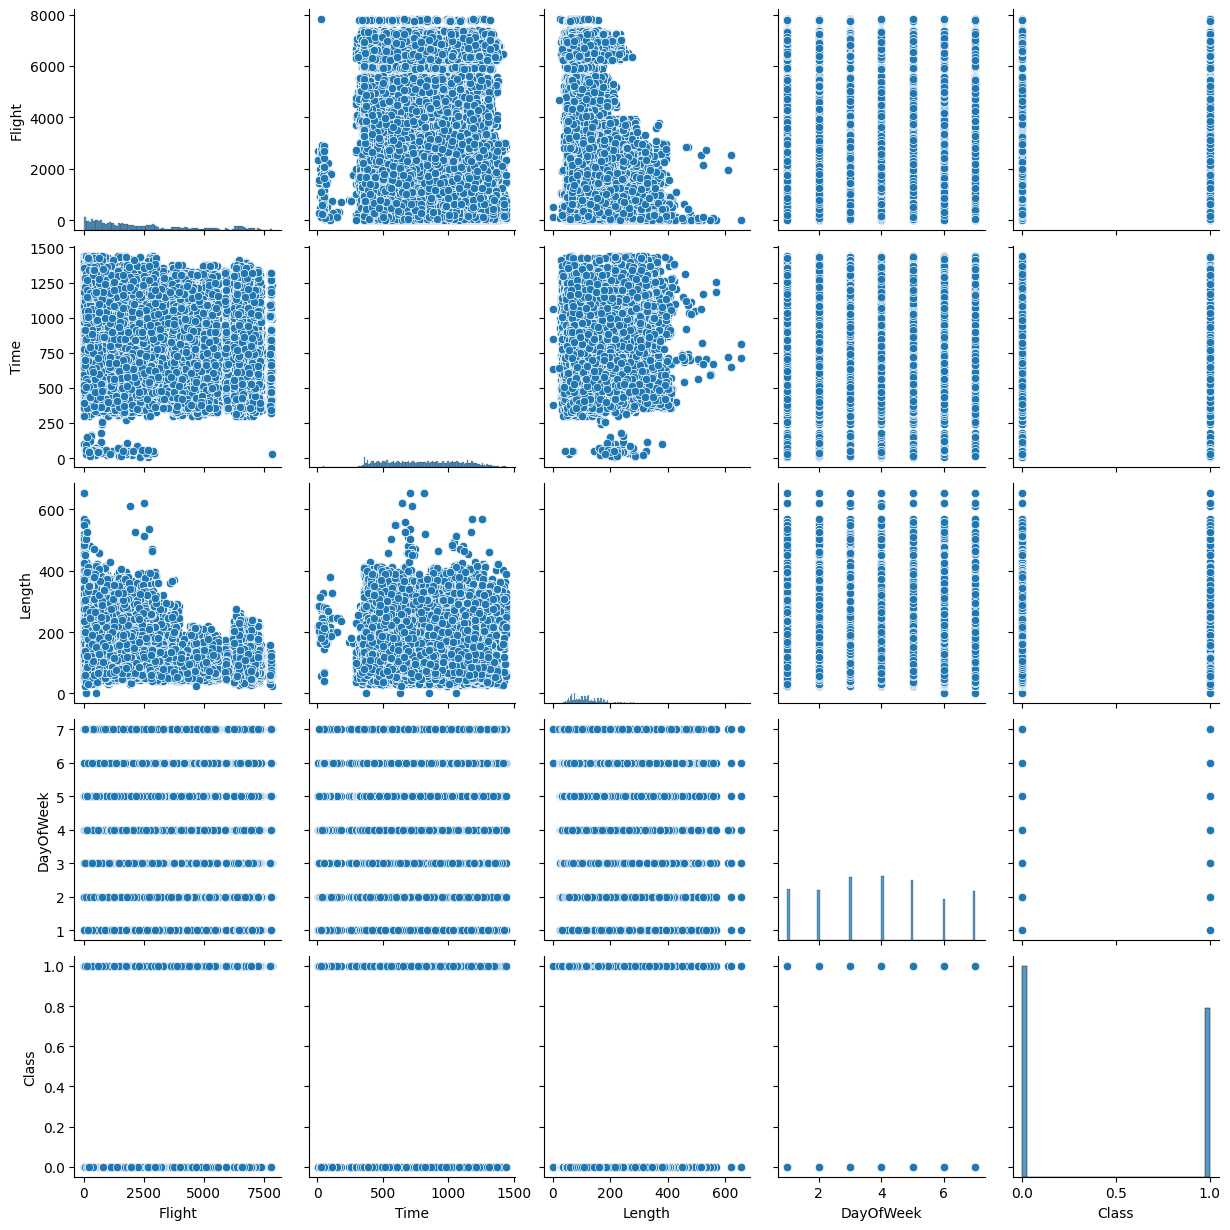

In [ ]:
sns.pairplot(df)

#  **Predictive Modeling**

## Preprocessing the data

### Encoding categorical variables

In [12]:
unique_airports = df['AirportFrom'].unique()
airport_mapping = {airport: i for i, airport in enumerate(unique_airports)}
df['AirportFrom'] = df['AirportFrom'].map(airport_mapping)
df['AirportTo'] = df['AirportTo'].map(airport_mapping)

In [10]:
df.sample(10)

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class,TimeOfDay,LengthBucket
178042,5309.0,794.0,131.0,EV,71,0,4,0,Afternoon,Medium
462743,827.0,525.0,70.0,WN,19,49,3,1,Morning,Short
72150,4509.0,810.0,45.0,OO,14,19,3,0,Afternoon,Short
444683,743.0,686.0,152.0,UA,43,96,7,0,Morning,Medium
162573,1082.0,765.0,120.0,DL,0,22,5,0,Afternoon,Medium
508384,2495.0,1150.0,180.0,AA,22,7,5,0,Evening,Medium
470896,3891.0,630.0,80.0,9E,22,21,2,1,Morning,Short
488792,526.0,975.0,171.0,CO,13,8,2,0,Afternoon,Medium
329219,1004.0,460.0,90.0,WN,139,118,2,0,Morning,Short
325017,320.0,970.0,165.0,UA,30,98,6,0,Afternoon,Medium


In [13]:
le = LabelEncoder()
df['TimeOfDay'] = le.fit_transform(df['TimeOfDay'])
df['LengthBucket'] = le.fit_transform(df['LengthBucket'])

In [ ]:
df.head(10)

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class,TimeOfDay,LengthBucket
0,2313.0,1296.0,141.0,DL,0,144,1,0,1,1
1,6948.0,360.0,146.0,OO,1,30,4,0,2,1
2,1247.0,1170.0,143.0,B6,2,12,3,0,1,1
3,31.0,1410.0,344.0,US,3,26,6,0,3,0
4,563.0,692.0,98.0,FL,4,0,4,0,2,2
5,3692.0,580.0,60.0,WN,5,20,4,0,2,2
6,1135.0,690.0,239.0,CO,6,7,4,0,2,1
7,1300.0,1210.0,80.0,AA,7,63,3,0,1,2
8,587.0,1295.0,105.0,FL,8,75,7,0,1,2
9,764.0,530.0,108.0,FL,0,31,3,0,2,2


In [15]:
# Applying One-Hot Encoding to the "Airline" column
df = pd.get_dummies(df, columns=['Airline'], prefix='Airline')
for col in df.columns:
    if col.startswith('Airline_'):
        df[col] = df[col].astype(int)


In [17]:
df.head()

,Flight,Time,Length,AirportFrom,AirportTo,DayOfWeek,Class,TimeOfDay,LengthBucket,Airline_9E,...,Airline_FL,Airline_HA,Airline_MQ,Airline_OH,Airline_OO,Airline_UA,Airline_US,Airline_WN,Airline_XE,Airline_YV
0,2313.0,1296.0,141.0,0,144,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,6948.0,360.0,146.0,1,30,4,0,2,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1247.0,1170.0,143.0,2,12,3,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,31.0,1410.0,344.0,3,26,6,0,3,0,0,...,0,0,0,0,0,0,1,0,0,0
4,563.0,692.0,98.0,4,0,4,0,2,2,0,...,1,0,0,0,0,0,0,0,0,0


In [19]:
# Features and target variable
X = df.drop(columns=['Class'])
y = df['Class']

### Information Gain for Feature Importance

         Feature  Information Gain
6      TimeOfDay          0.042219
23    Airline_WN          0.033721
7   LengthBucket          0.030106
0         Flight          0.022007
1           Time          0.020240
3    AirportFrom          0.017707
4      AirportTo          0.015440
5      DayOfWeek          0.010704
2         Length          0.008752
13    Airline_DL          0.003474
21    Airline_UA          0.003060
9     Airline_AA          0.002969
16    Airline_FL          0.002759
22    Airline_US          0.002651
18    Airline_MQ          0.002596
8     Airline_9E          0.002306
14    Airline_EV          0.002100
12    Airline_CO          0.001871
25    Airline_YV          0.001789
20    Airline_OO          0.001669
24    Airline_XE          0.001483
17    Airline_HA          0.001444
10    Airline_AS          0.001346
15    Airline_F9          0.001065
19    Airline_OH          0.000388
11    Airline_B6          0.000000


Text(0, 0.5, 'Information Gain')

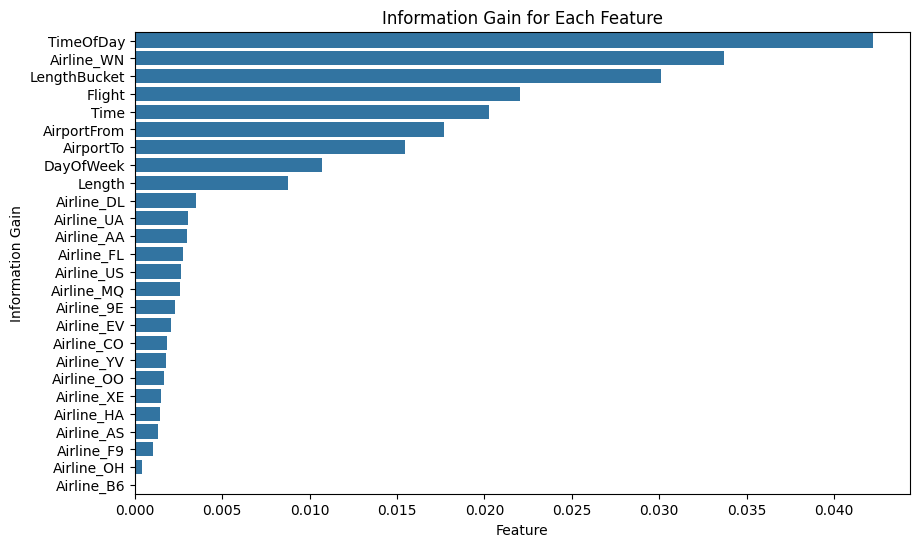

In [20]:
information_gain = mutual_info_classif(X, y, discrete_features='auto')
info_gain_df = pd.DataFrame({'Feature': X.columns, 'Information Gain': information_gain})
info_gain_df = info_gain_df.sort_values(by='Information Gain', ascending=False)

print(info_gain_df)

# ploting the results
plt.figure(figsize=(10,6))
sns.barplot(x='Information Gain', y='Feature', data=info_gain_df)
plt.title('Information Gain for Each Feature')
plt.xlabel('Feature')
plt.ylabel('Information Gain')


## Model Training

In [22]:
# Initializing the KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression with K-Fold Cross Validation

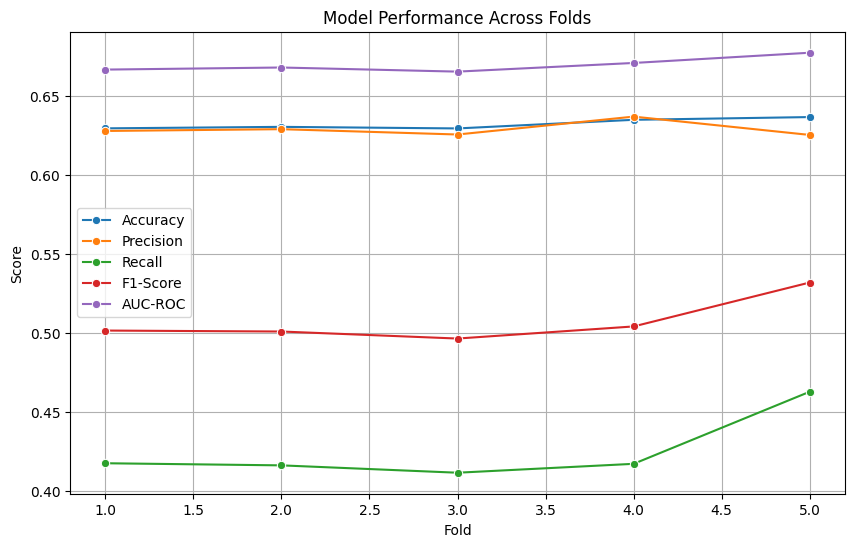

In [27]:
model = LogisticRegression(max_iter=1000)

# Defining scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# cross-validation
cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring)

# Extracting the metrics
accuracy = cv_results['test_accuracy']
precision = cv_results['test_precision']
recall = cv_results['test_recall']
f1 = cv_results['test_f1']
roc_auc = cv_results['test_roc_auc']

# Creating a DataFrame to hold the results
metrics_df = pd.DataFrame({
    'Fold': np.arange(1, kf.get_n_splits(X) + 1),
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC-ROC': roc_auc
})

# Plotting the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=metrics_df, x='Fold', y='Accuracy', marker='o', label='Accuracy')
sns.lineplot(data=metrics_df, x='Fold', y='Precision', marker='o', label='Precision')
sns.lineplot(data=metrics_df, x='Fold', y='Recall', marker='o', label='Recall')
sns.lineplot(data=metrics_df, x='Fold', y='F1-Score', marker='o', label='F1-Score')
sns.lineplot(data=metrics_df, x='Fold', y='AUC-ROC', marker='o', label='AUC-ROC')

plt.title('Model Performance Across Folds')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()



### Random Forest Classifier with K-Fold Cross Validation

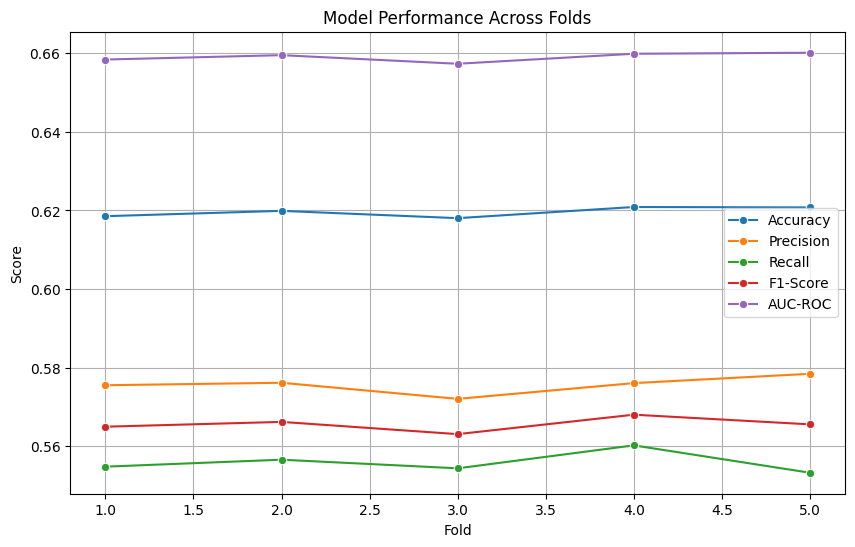

In [29]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring)

accuracy = cv_results['test_accuracy']
precision = cv_results['test_precision']
recall = cv_results['test_recall']
f1 = cv_results['test_f1']
roc_auc = cv_results['test_roc_auc']

metrics_df = pd.DataFrame({
    'Fold': np.arange(1, kf.get_n_splits(X) + 1),
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC-ROC': roc_auc
})

# Plotting the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=metrics_df, x='Fold', y='Accuracy', marker='o', label='Accuracy')
sns.lineplot(data=metrics_df, x='Fold', y='Precision', marker='o', label='Precision')
sns.lineplot(data=metrics_df, x='Fold', y='Recall', marker='o', label='Recall')
sns.lineplot(data=metrics_df, x='Fold', y='F1-Score', marker='o', label='F1-Score')
sns.lineplot(data=metrics_df, x='Fold', y='AUC-ROC', marker='o', label='AUC-ROC')

plt.title('Model Performance Across Folds')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

### Logistic Regression with Train Test Split

Accuracy: 0.6293093059688348
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.80      0.71     59714
           1       0.63      0.42      0.50     48163

    accuracy                           0.63    107877
   macro avg       0.63      0.61      0.60    107877
weighted avg       0.63      0.63      0.61    107877

Confusion Matrix:
[[47805 11909]
 [28080 20083]]


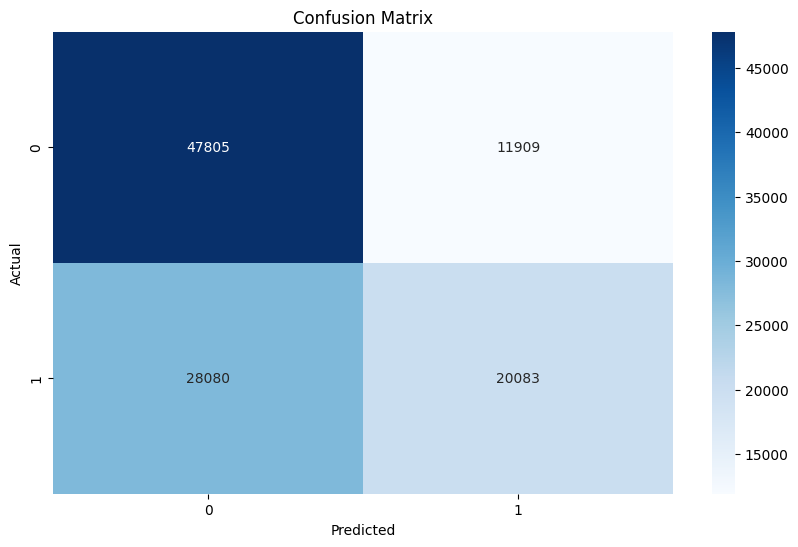

In [28]:
model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)

# plotting the  results
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Random Forest with Train Test Split

Accuracy: 0.6179908599608813
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.67      0.66     59714
           1       0.57      0.55      0.56     48163

    accuracy                           0.62    107877
   macro avg       0.61      0.61      0.61    107877
weighted avg       0.62      0.62      0.62    107877

Confusion Matrix:
[[40000 19714]
 [21496 26667]]


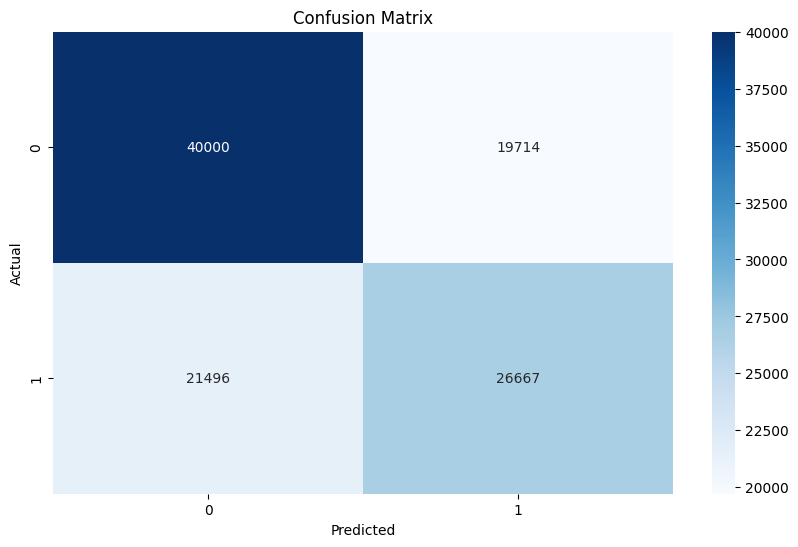

In [30]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)

# plotting the results
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **...**